# Table of Contents
- [STATIONARITY & TRANSFORMATIONS](#stationarity--transformations)
   - [Data Cleaning](#data-cleaning)
     - [Missing Values](#missing-values)
     - [Outliers](#outliers)
   - [Stationarity](#STATIONARITY)
     - [ACF and PACF functions](#acf-and-pacf-functions)
     - [Statistical Tests](#statistical-tests)
   - [Transformation](#transformation)
- [ARIMA MODEL](#arima-model)
- [FORECASTS](#forecasts)
- [BONUS points](#bonus-points)


In [1]:
import os
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.ensemble import IsolationForest

from statsmodels.tsa.stattools import adfuller, kpss

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import root_mean_squared_error

# STATIONARITY & TRANSFROMATIONS

## Data Cleaning

Clean the data of outliers or breaks

### Missing Values

In [2]:
# Load data
os.chdir('.')  # Set working directory to your file's location
df = pd.read_csv('DCOILBRENTEU.csv')
df.columns = ['date', 'y']

# Convert 'date' column to datetime and check its data type
df['date'] = pd.to_datetime(df['date'])
print("Data types after converting 'date':\n", df.dtypes)
print("-"*50)

# Remove time part (hour:min:sec) from 'date' column
df['date'] = df['date'].dt.date
print("Data types after removing time part from 'date':\n", df.dtypes)
print("-"*50)

# Convert 'y' column to numeric and check its data type
df['y'] = pd.to_numeric(df['y'], errors='coerce')
print("Data types after converting 'y' to numeric:\n", df.dtypes)
print("-"*50)

Data types after converting 'date':
 date    datetime64[ns]
y               object
dtype: object
--------------------------------------------------
Data types after removing time part from 'date':
 date    object
y       object
dtype: object
--------------------------------------------------
Data types after converting 'y' to numeric:
 date     object
y       float64
dtype: object
--------------------------------------------------


In [3]:
df

,date,y
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
9749,2024-10-01,75.30
9750,2024-10-02,74.86
9751,2024-10-03,77.57
9752,2024-10-04,79.32


In [4]:
# Select the first 1000 rows
df = df.iloc[:1000]

For this project we use first 1000 samples of this time series.

In [5]:
df

,date,y
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63
...,...,...
995,1991-03-13,20.33
996,1991-03-14,19.98
997,1991-03-15,19.05
998,1991-03-18,18.30


In [6]:
print("Missing values:\n", df.isna().sum())

# Fill missing values in 'y' using a moving average with a specified window size
window_size = 5
df['y'] = df['y'].fillna(df['y'].rolling(window=window_size, min_periods=1).mean())

print("Missing values after Moving Average:\n", df.isna().sum())

Missing values:
 date     0
y       20
dtype: int64
Missing values after Moving Average:
 date    0
y       0
dtype: int64


We can replace each missing point with the average of the rolling window around it.
this code identifyies missing values in the y column and then fills these breaks with a smoothed estimate (moving average), thus maintaining continuity in the time series data.

### Outliers

In [7]:
# Calculate the first and third quartiles (Q1 and Q3)
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
df['outlier_iqr'] = (df['y'] < lower_bound) | (df['y'] > upper_bound)

# Count the number of outliers detected
outliers_count = df['outlier_iqr'].sum()
print(f"Number of outliers detected: {outliers_count}")

Number of outliers detected: 116


In [8]:
# Define the rolling window size
window_size = 10

# Calculate the rolling mean and rolling standard deviation
rolling_mean = df['y'].rolling(window=window_size, center=True).mean()
rolling_std = df['y'].rolling(window=window_size, center=True).std()

# Define outliers as points beyond 3 standard deviations from the rolling mean
df['outlier_moving'] = ((df['y'] > rolling_mean + 3 * rolling_std) | 
                        (df['y'] < rolling_mean - 3 * rolling_std))

# Count the number of outliers detected
outliers_count_moving = df['outlier_moving'].sum()
print(f"Number of outliers detected with moving method: {outliers_count_moving}")

Number of outliers detected with moving method: 0


Here we compute a rolling mean and rolling standard deviation over a specified window and then flag data points that deviate significantly from the rolling mean (e.g., by more than 3 standard deviations).

In [9]:
# Train Isolation Forest
model = IsolationForest(contamination=0.001)  # we can set contamination to adjust sensitivity
df['outlier_iforest'] = model.fit_predict(df[['y']]) == -1

# Count the number of outliers detected
outliers_count_iforest = df['outlier_iforest'].sum()
print(f"Number of outliers detected with Isolation Forest: {outliers_count_iforest}")

Number of outliers detected with Isolation Forest: 1


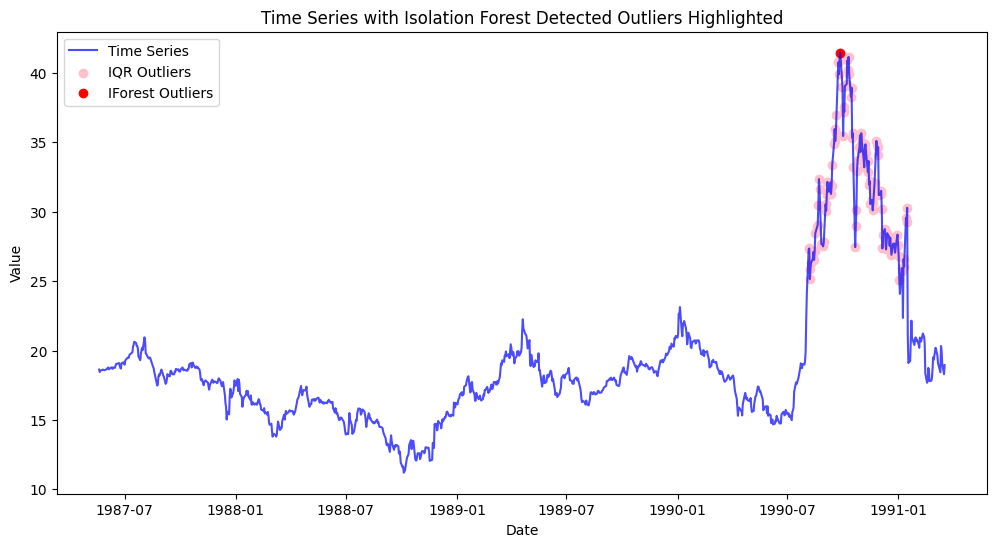

In [10]:
# Plot the entire time series
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['y'], label='Time Series', color='blue', alpha=0.7)

# Highlight detected outliers in red

plt.scatter(df['date'][df['outlier_iqr']], df['y'][df['outlier_iqr']], color='pink', label='IQR Outliers', marker='o')
plt.scatter(df['date'][df['outlier_iforest']], df['y'][df['outlier_iforest']], color='red', label='IForest Outliers', marker='o')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series with Isolation Forest Detected Outliers Highlighted')
plt.legend()
plt.show()

In [11]:
# Define a rolling window size
window_size = 5

# Replace outliers with rolling mean
df['y'] = df['y'].where(~df['outlier_iforest'], df['y'].rolling(window=window_size, min_periods=1).mean())

We replaced each outlier with the average of a surrounding window of values. This smooths out the effect of the outlier, maintaining the overall trend without the influence of extreme values. We just hanlded the `outlier_iforest` because `outlier_iqr` was too much and not reliable based on the plot :)

## STATIONARITY

Decide and describe whether the series is stationary or not. support your argument with ACF and PACF functions, as well as statistical tests.

### ACF and PACF functions

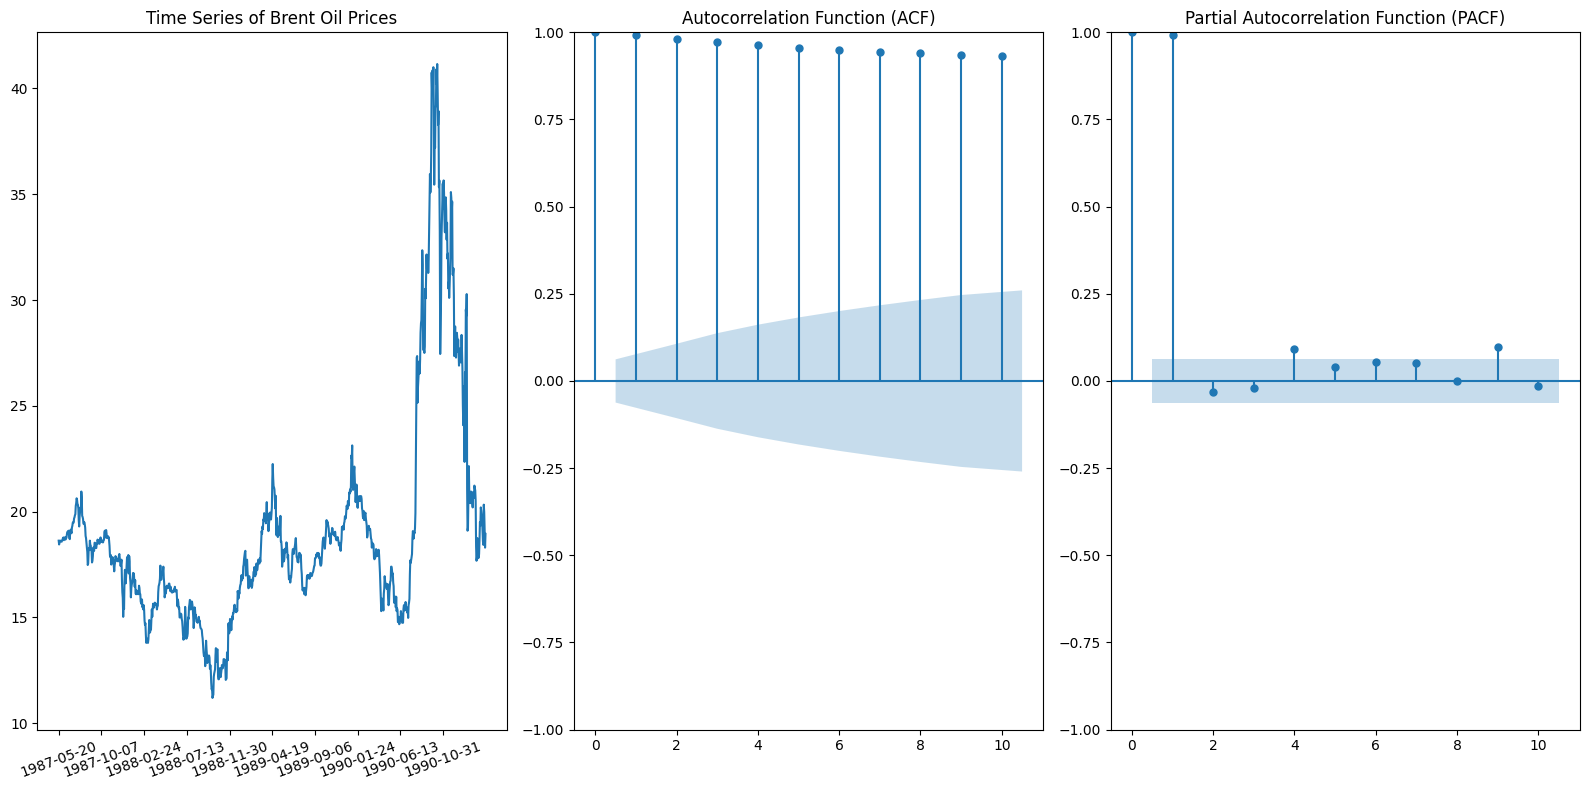

In [12]:
# Plotting
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

# Plot the 'y' column (oil prices over time)
n_tick = 100  # Number of ticks to display
axs[0].plot(df.y)

# Set x-ticks and x-tick labels
xticks = np.arange(0, len(df.y), n_tick)
axs[0].set_xticks(xticks)

# Ensure that the number of labels matches the number of ticks
xtick_labels = df.date.iloc[xticks].astype(str)  # Convert dates to strings for labeling
axs[0].set_xticklabels(xtick_labels, rotation=20)

# Set title for the first plot
axs[0].set_title('Time Series of Brent Oil Prices')

# Plot the autocorrelation function (ACF) and partial autocorrelation function (PACF)
sm.graphics.tsa.plot_acf(df.y, lags=10, ax=axs[1])
axs[1].set_title('Autocorrelation Function (ACF)')

sm.graphics.tsa.plot_pacf(df.y, lags=10, ax=axs[2])
axs[2].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

- **Time Series Plot:**
The time series shows clear upward and downward trends over different periods, along with noticeable peaks and troughs.
This suggests non-stationarity, as the series does not have a constant mean or variance over time.

- **Autocorrelation Function (ACF) Plot:**
The ACF plot shows significant autocorrelation at multiple lags, with slow decay. This is typical for non-stationary series, as the values are highly correlated with previous values.
Slow decay in the ACF indicates a trend or persistence over time, which reinforces the likelihood of non-stationarity.

- **Partial Autocorrelation Function (PACF) Plot:**
The PACF shows a high value at the first lag and then drops off significantly.
This pattern can sometimes suggest that the series may become stationary after differencing once.


### Statistical Tests

To statistically determine whether the time series is stationary, we use two stationarity tests as the **Augmented Dickey-Fuller (ADF)** Test and **Kwiatkowski-Phillips-Schmidt-Shin (KPSS)** Test.

The **ADF** test is used to check for the presence of a unit root in the series, which indicates non-stationarity.
- Null Hypothesis $(H_0)$: The series has a unit root (it is non-stationary).
- Alternative Hypothesis $(H_1)$: The series is stationary.
- Interpretation: If the p-value is less than 0.05, we reject the null hypothesis and conclude that the series is stationary. If the p-value is greater than 0.05, we fail to reject the null, indicating that the series is likely non-stationary.

The **KPSS** test is another statistical test for stationarity, but with the opposite null hypothesis compared to the ADF test.
- Null Hypothesis $(H_0)$: The series is stationary.
- Alternative Hypothesis $(H_1)$: The series is non-stationary.
- Interpretation: If the p-value is less than 0.05, we reject the null hypothesis and conclude that the series is likely non-stationary.

In [13]:
# Augmented Dickey-Fuller (ADF) Test
adf_test = adfuller(df['y'], maxlag=30, regression='ct', autolag='AIC') # 'c' for constant, 'ct' for constant + trend
print("Augmented Dickey-Fuller (ADF) Test:")
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"   {key}: {value}")
if adf_test[1] < 0.05:
    print("Conclusion: The series is likely stationary (p-value < 0.05).")
else:
    print("Conclusion: The series is likely non-stationary (p-value >= 0.05).")

# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
kpss_test = kpss(df['y'], regression='ct', nlags='auto')  # 'c' for constant, 'ct' for constant + trend
print("\nKwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
print(f"KPSS Statistic: {kpss_test[0]}")
print(f"p-value: {kpss_test[1]}")
print("Critical Values:")
for key, value in kpss_test[3].items():
    print(f"   {key}: {value}")
if kpss_test[1] < 0.05:
    print("Conclusion: The series is likely non-stationary (p-value < 0.05).")
else:
    print("Conclusion: The series is likely stationary (p-value >= 0.05).")

Augmented Dickey-Fuller (ADF) Test:
ADF Statistic: -3.1210325231559617
p-value: 0.10131542133218713
Critical Values:
   1%: -3.9680661492141187
   5%: -3.414993271500572
   10%: -3.1297006047557043
Conclusion: The series is likely non-stationary (p-value >= 0.05).

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
KPSS Statistic: 0.4056803182956184
p-value: 0.01
Critical Values:
   10%: 0.119
   5%: 0.146
   2.5%: 0.176
   1%: 0.216
Conclusion: The series is likely non-stationary (p-value < 0.05).


In Augmented Dickey-Fuller (ADF) Test, we fail to reject the null hypothesis of the ADF test, which suggests that the series is likely non-stationary.
In Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test, we reject the null hypothesis of the KPSS test, indicating non-stationarity.

Both the ADF and KPSS tests suggest that the series is non-stationary.

## Transformation

Explain which transformation you will use to make the series stationary and 
ready for modelling.

this series appears to be non-stationary and to make it stationary, we will apply first-order differencing. This transformation can often remove trends and stabilize the mean.

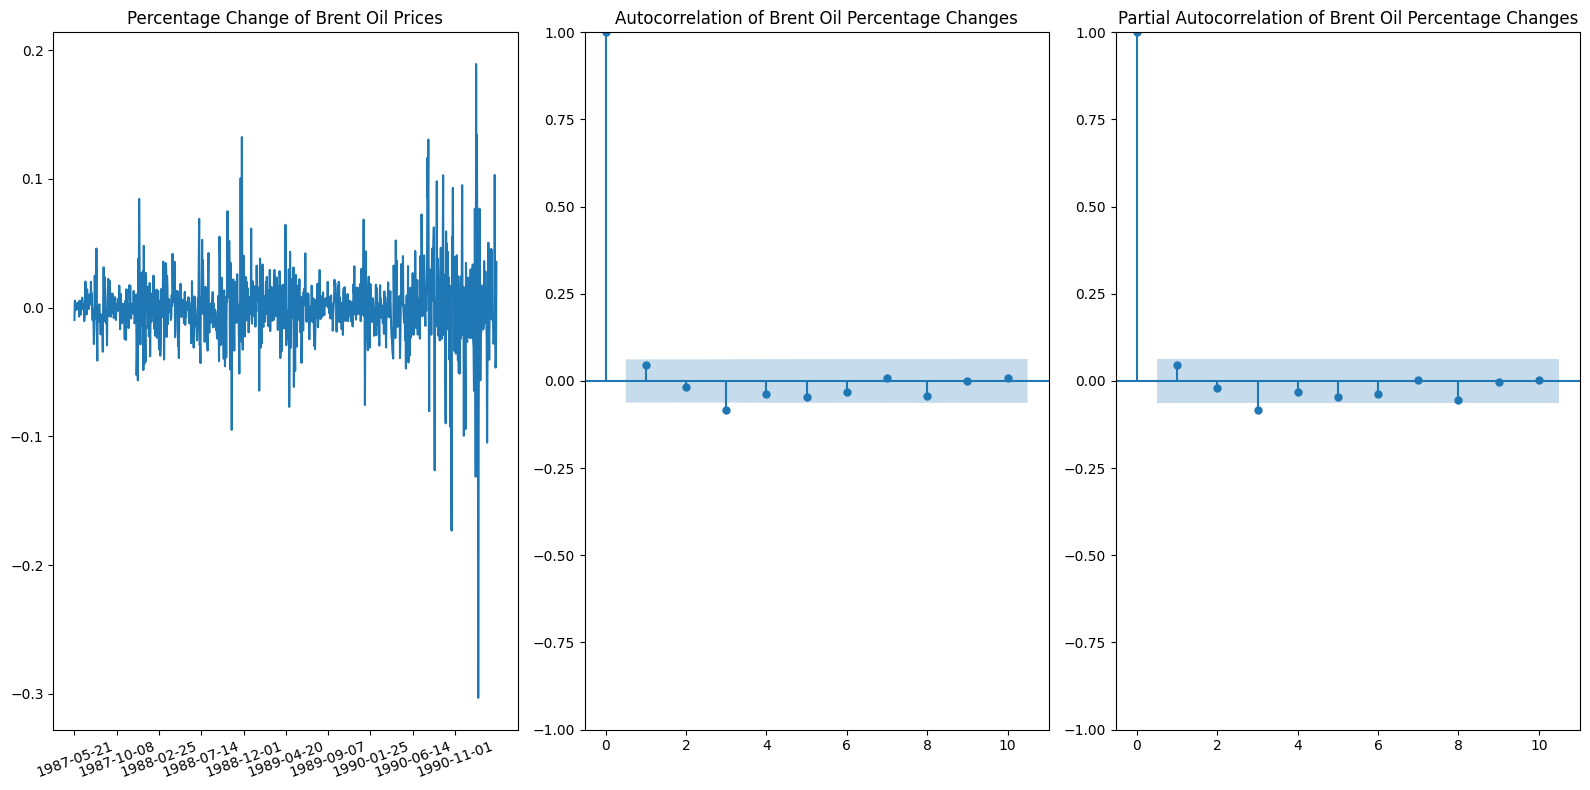

In [14]:
# Calculate percentage change
df['dy'] = df['y'].pct_change()

# Drop NaN values after calculating percentage change and Reset index after dropping NaNs
df_dy = df.dropna(subset=['dy']).reset_index(drop=True)

# Plots
fig, axs = plt.subplots(1, 3, figsize=(16, 8))

# Plot the percentage change (dy)
n_tick = 100  # Set tick frequency
axs[0].plot(df_dy['dy'])

# Set x-ticks and x-tick labels
xticks = np.arange(0, len(df_dy['dy']), n_tick)  # Display every n-th tick
axs[0].set_xticks(xticks)

# Ensure that the number of labels matches the number of ticks
xtick_labels = df_dy['date'].iloc[xticks].astype(str)  # Extract corresponding date labels
axs[0].set_xticklabels(xtick_labels, rotation=20)

# Set title for the first plot
axs[0].set_title('Percentage Change of Brent Oil Prices')

# Plot the autocorrelation function (ACF) for percentage changes
sm.graphics.tsa.plot_acf(df_dy['dy'], lags=10, ax=axs[1])
axs[1].set_title('Autocorrelation of Brent Oil Percentage Changes')

# Plot the partial autocorrelation function (PACF) for percentage changes
sm.graphics.tsa.plot_pacf(df_dy['dy'], lags=10, ax=axs[2])
axs[2].set_title('Partial Autocorrelation of Brent Oil Percentage Changes')
plt.tight_layout()
plt.show()

In [15]:
# Augmented Dickey-Fuller (ADF) Test
adf_test = adfuller(df_dy['dy'], maxlag=30, regression='c', autolag='AIC') # 'c' for constant, 'ct' for constant + trend
print("Augmented Dickey-Fuller (ADF) Test:")
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"   {key}: {value}")
if adf_test[1] < 0.05:
    print("Conclusion: The series is likely stationary (p-value < 0.05).")
else:
    print("Conclusion: The series is likely non-stationary (p-value >= 0.05).")

# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
kpss_test = kpss(df_dy['dy'], regression='c', nlags='auto')  # 'c' for constant, 'ct' for constant + trend
print("\nKwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:")
print(f"KPSS Statistic: {kpss_test[0]}")
print(f"p-value: {kpss_test[1]}")
print("Critical Values:")
for key, value in kpss_test[3].items():
    print(f"   {key}: {value}")
if kpss_test[1] < 0.05:
    print("Conclusion: The series is likely non-stationary (p-value < 0.05).")
else:
    print("Conclusion: The series is likely stationary (p-value >= 0.05).")

Augmented Dickey-Fuller (ADF) Test:
ADF Statistic: -4.670464823385718
p-value: 9.558688373394208e-05
Critical Values:
   1%: -3.43706091543889
   5%: -2.8645028204932483
   10%: -2.568347558984588
Conclusion: The series is likely stationary (p-value < 0.05).

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
KPSS Statistic: 0.10033121581918028
p-value: 0.1
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
Conclusion: The series is likely stationary (p-value >= 0.05).


Number of outliers detected with Isolation Forest on dy: 1


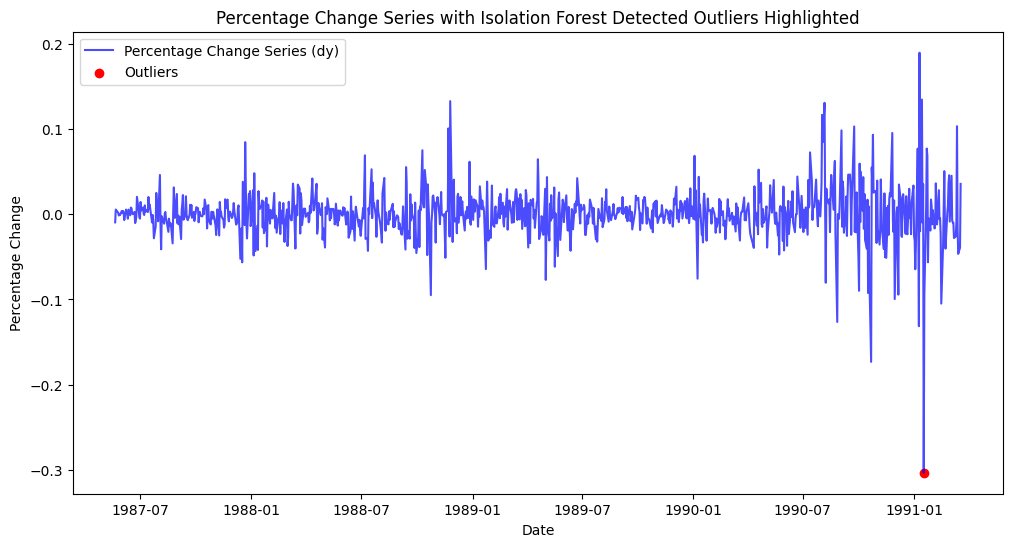

In [16]:
# Train Isolation Forest on df_dy for dy (percentage changes)
model_dy = IsolationForest(contamination=0.001)
df_dy['outlier_iforest_dy'] = model_dy.fit_predict(df_dy[['dy']]) == -1

# Count the number of outliers detected
outliers_count_iforest_dy = df_dy['outlier_iforest_dy'].sum()
print(f"Number of outliers detected with Isolation Forest on dy: {outliers_count_iforest_dy}")

# Plot the percentage change series with outliers
plt.figure(figsize=(12, 6))
plt.plot(df_dy['date'], df_dy['dy'], label='Percentage Change Series (dy)', color='blue', alpha=0.7)
plt.scatter(df_dy['date'][df_dy['outlier_iforest_dy']], df_dy['dy'][df_dy['outlier_iforest_dy']], color='red', label='Outliers', marker='o')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.title('Percentage Change Series with Isolation Forest Detected Outliers Highlighted')
plt.legend()
plt.show()

In [17]:
# Smooth only the outliers with a rolling mean
df_dy['dy_smoothed'] = df_dy['dy']
outlier_indices = df_dy['outlier_iforest_dy']
df_dy.loc[outlier_indices, 'dy_smoothed'] = df_dy['dy'].rolling(window=7, min_periods=1).mean()[outlier_indices]

In [18]:
df_dy

,date,y,outlier_iqr,outlier_moving,outlier_iforest,dy,outlier_iforest_dy,dy_smoothed
0,1987-05-21,18.45,False,False,False,-0.009662,False,-0.009662
1,1987-05-22,18.55,False,False,False,0.005420,False,0.005420
2,1987-05-25,18.60,False,False,False,0.002695,False,0.002695
3,1987-05-26,18.63,False,False,False,0.001613,False,0.001613
4,1987-05-27,18.60,False,False,False,-0.001610,False,-0.001610
...,...,...,...,...,...,...,...,...
994,1991-03-13,20.33,False,False,False,0.103093,False,0.103093
995,1991-03-14,19.98,False,False,False,-0.017216,False,-0.017216
996,1991-03-15,19.05,False,False,False,-0.046547,False,-0.046547
997,1991-03-18,18.30,False,False,False,-0.039370,False,-0.039370


# ARIMA MODEL

Take the stationary series from point 1, use the first 80% of the sample 
for estimation, and select an appropriate ARIMA model. Justify your choice by means of tests and 
selection criteria.

In [19]:
y_stationary = df_dy['dy_smoothed']

# Split into training and testing sets (80% train, 20% test)
train_size = int(len(y_stationary) * 0.8)
y_train, y_test = y_stationary[:train_size], y_stationary[train_size:]

In [20]:
# PART 1: Decide on the appropriate ARIMA(p,d,q) model
# Estimate optimal (p, q) using AIC, BIC, and HQIC
IC = sm.tsa.stattools.arma_order_select_ic(y_train, max_ar=4, max_ma=4, ic=['aic', 'bic', 'hqic'], trend='c')
print(f"Optimal (p, q) by AIC: {IC.aic_min_order}")
print(f"Optimal (p, q) by BIC: {IC.bic_min_order}")
print(f"Optimal (p, q) by HQIC: {IC.hqic_min_order}")

Optimal (p, q) by AIC: (1, 1)
Optimal (p, q) by BIC: (0, 0)
Optimal (p, q) by HQIC: (1, 1)


In [21]:
# PART 2: Fit the best ARIMA model from information criteria
best_order = IC.aic_min_order
print("best order:", best_order)
mod = sm.tsa.arima.ARIMA(y_train, order=(best_order[0], 0, best_order[1]), trend='c', validate_specification=True)
res = mod.fit()
print(res.summary())

best order: (1, 1)
                               SARIMAX Results                                
Dep. Variable:            dy_smoothed   No. Observations:                  799
Model:                 ARIMA(1, 0, 1)   Log Likelihood                2000.180
Date:                Sun, 03 Nov 2024   AIC                          -3992.360
Time:                        20:41:57   BIC                          -3973.627
Sample:                             0   HQIC                         -3985.163
                                - 799                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.475e-05      0.001     -0.117      0.907      -0.002       0.001
ar.L1         -0.9584      0.012    -81.793      0.000      -0.981      -0.935
ma.L1          0.9959      0.005 

Based on the ARIMA(1,0,1) model results, here’s some interpretation:

- **AR(1) Coefficient (ar.L1):** The autoregressive coefficient is -0.9584, which is strongly significant (p-value = 0.000). This negative value suggests a strong inverse relationship with the previous observation.
- **MA(1) Coefficient (ma.L1):** The moving average coefficient is 0.9959, also highly significant (p-value = 0.000). This indicates that the model adjusts quickly for recent shocks.
- **Constant Term (const):** The constant term is very close to zero (-8.475e-05) and not statistically significant (p-value = 0.907). This implies that there isn’t a significant overall drift or trend in the stationary series.
- **Sigma Squared (sigma2):** sigma2 represents the estimated variance of the residuals, at 0.0004. This relatively low value suggests that the model captures a substantial amount of variance in the data.
- **AIC (-3992.360), BIC (-3973.627), HQIC (-3985.163):** These criteria help assess model fit while penalizing complexity.
Lower values indicate a better model. Here, AIC is used for initial model selection, but all criteria suggest a good fit.
- **Ljung-Box Test (Prob(Q) = 0.88):** The p-value for the Ljung-Box test (L1) is 0.88, which is much greater than 0.05. This indicates that there is no significant autocorrelation in the residuals, meaning the model has effectively captured the serial correlation structure of the series.
- **Jarque-Bera Test (Prob(JB) = 0.00):** The very low p-value for the Jarque-Bera test suggests that the residuals are not normally distributed, likely due to excess kurtosis (7.85). This could be caused by extreme values or "fat tails" in the distribution of residuals.
- **Heteroscedasticity Test (Prob(H) = 1.00):** The p-value of 1.00 for the heteroscedasticity test indicates no evidence of heteroscedasticity, suggesting that the residuals have constant variance over time.

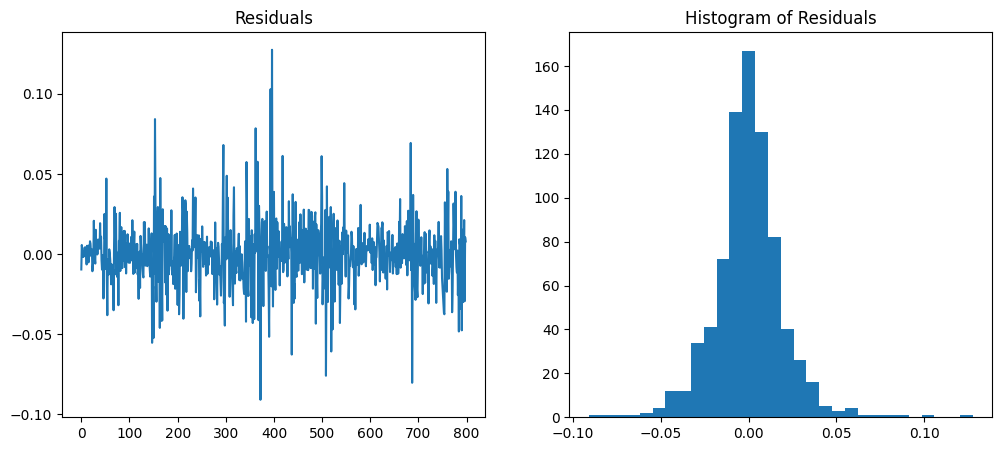

In [22]:
# PART 3: Residual Analysis
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(res.resid, label='Residuals')
axs[0].set_title("Residuals")
axs[1].hist(res.resid, bins=30)
axs[1].set_title("Histogram of Residuals")
plt.show()

- The residuals fluctuate around zero without any apparent trend, which is a good sign. This suggests that the ARIMA model has successfully removed any systematic patterns from the data.
- The histogram indicates some deviation from normality, with a tendency toward heavier tails. This could lead to occasional larger-than-expected residuals, but it may not significantly impact forecasting.

In [23]:
# PART 4: Fit Adjacent Models
print("Estimate adjacent models for comparison:")
mod_ar2 = sm.tsa.arima.ARIMA(y_train, order=(best_order[0]+1, 0, best_order[1]), trend='c')
res_ar2 = mod_ar2.fit()
print(res_ar2.summary())

mod_ma1 = sm.tsa.arima.ARIMA(y_train, order=(best_order[0], 0, best_order[1]+1), trend='c')
res_ma1 = mod_ma1.fit()
print(res_ma1.summary())

Estimate adjacent models for comparison:
                               SARIMAX Results                                
Dep. Variable:            dy_smoothed   No. Observations:                  799
Model:                 ARIMA(2, 0, 1)   Log Likelihood                1997.123
Date:                Sun, 03 Nov 2024   AIC                          -3984.246
Time:                        20:42:02   BIC                          -3960.829
Sample:                             0   HQIC                         -3975.249
                                - 799                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.049e-05      0.001     -0.115      0.908      -0.001       0.001
ar.L1         -0.2803      0.284     -0.986      0.324      -0.838       0.277
ar.L2      

By comparing the results of ARIMA(1, 0, 1) (the initial "best" model) with the adjacent models ARIMA(2, 0, 1) and ARIMA(1, 0, 2), we can see still ARIMA(1, 0, 1) fits better. It offers the best balance between simplicity and model fit, with significant parameters and well-behaved residuals.

In [24]:
# Test residuals for autocorrelation (Ljung-Box test)
res_lb = sm.stats.diagnostic.acorr_ljungbox(res.resid, lags=10, boxpierce=True, model_df=best_order[0] + best_order[1])
print("Ljung-Box test for residual autocorrelation:")
print(res_lb)

# Test residuals for heteroscedasticity
res_het = sm.tsa.stattools.breakvar_heteroskedasticity_test(res.resid, subset_length=1/3, alternative='two-sided')
print("Heteroscedasticity test p-value:", res_het[1])

Ljung-Box test for residual autocorrelation:
      lb_stat  lb_pvalue    bp_stat  bp_pvalue
1    0.021670        NaN   0.021589        NaN
2    1.844713        NaN   1.835528        NaN
3    1.848320   0.173979   1.839113   0.175055
4    1.916010   0.383658   1.906295   0.385526
5    2.146460   0.542571   2.134731   0.544918
6    3.799219   0.433860   3.770984   0.437886
7    4.098705   0.535294   4.067105   0.539796
8    4.711280   0.581340   4.672031   0.586511
9    9.909624   0.193753   9.798988   0.200254
10  13.074471   0.109313  12.916422   0.114758
Heteroscedasticity test p-value: 0.9855214414418006


Across all lags up to 10, the p-values are relatively high (all are greater than 0.05), indicating no significant autocorrelation in the residuals.
This is a good result, as it suggests that the ARIMA(1,0,1) model has effectively removed autocorrelation, meaning the residuals behave like white noise up to lag 10.
The NaN values in the lb_pvalue and bp_pvalue columns for the first two lags are likely due to insufficient degrees of freedom when calculating these statistics, which can happen for small samples at very low lags. This is typically not a concern, and we focus on higher lags for meaningful autocorrelation testing.
The very high p-value suggests no significant heteroscedasticity in the residuals. This means that the residuals likely have a constant variance over time, which is an important assumption for ARIMA models.

# FORECASTS
Use the model from point 2 and perform one-step-ahead forecasts, with 
expanding window, for your series for the remaining 20% of the sample (you can refer to the code 
from “Ex_multi_TS_real_data.ipynb”). Plot the forecasts and the true values. Also, report the RMSE of 
the forecasts. You will later compare this RMSE to the RMSE obtained in a VAR and NN model. For 
example, if you have 100 observations, the 1st one-step-ahead forecast: Estimate the model on T = 
1...80 and forecast the value for T=81. The 2nd one-step-ahead forecast: Estimate the model on T = 
1...81 and forecast T=82, and so on. 

In [25]:
len(y_test)

200

One-Step-Ahead Forecast RMSE: 0.04587713996921393


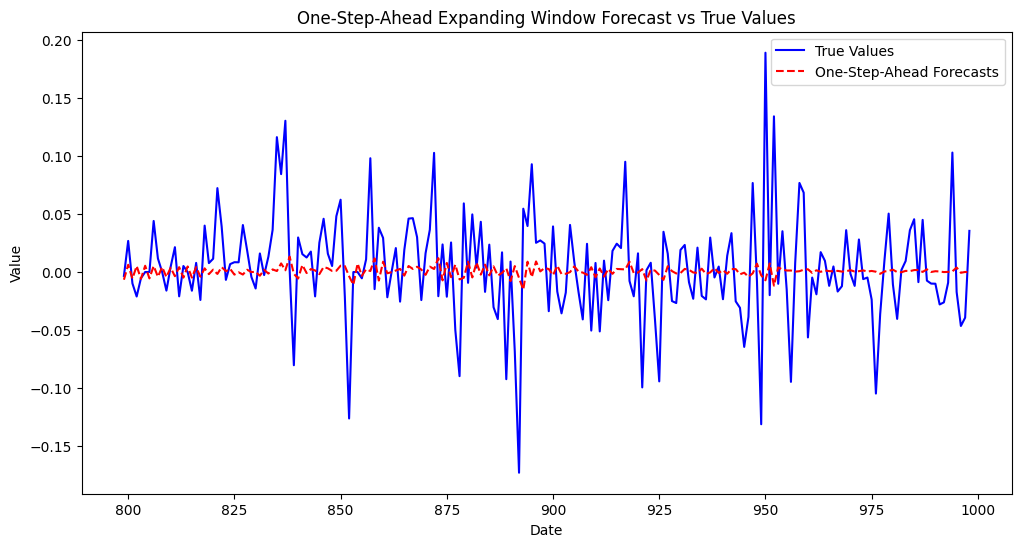

In [26]:
# Initialize a list to store the one-step-ahead forecasts
one_step_forecasts = []

# Expanding window forecast
for i in range(len(y_test)):
    # Expand the training set by one observation at each step
    train_data = y_stationary[:train_size + i]
    
    # Fit the ARIMA(1,0,1) model on the current training data
    model = sm.tsa.arima.ARIMA(train_data, order=(1, 0, 1), trend='c')
    fitted_model = model.fit()
    
    # Perform one-step-ahead forecast and store the forecasted value
    forecast = fitted_model.forecast(steps=1)
    forecast_value = forecast.iloc[0]  # Extract the forecasted scalar value
    one_step_forecasts.append(forecast_value)
    # print(f"Forecasted value at time {i + train_size}: {forecast_value}")

# Calculate the RMSE of the one-step-ahead forecasts
rmse = root_mean_squared_error(y_test, one_step_forecasts)
print(f"One-Step-Ahead Forecast RMSE: {rmse}")

# Convert forecasts and true values to pandas series for easy plotting
forecast_series = pd.Series(one_step_forecasts, index=y_test.index)
true_series = y_test

# Plot the forecasts against the actual values
plt.figure(figsize=(12, 6))
plt.plot(true_series, label='True Values', color='blue')
plt.plot(forecast_series, label='One-Step-Ahead Forecasts', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('One-Step-Ahead Expanding Window Forecast vs True Values')
plt.legend()
plt.show()

this code performs one-step-ahead forecasts with an expanding window.
This approach fits the model iteratively on each subset of the data, expanding the training set by one observation each time and generating a single forecast for the next point.
We predict each point in the test set using only the information available up to the preceding point, simulating how we would forecast in a real-time scenario.

An RMSE of 0.04588 suggests that, on average, the model's one-step-ahead forecasts deviate from the actual test values by about 0.0459 units.

The ARIMA model’s forecasts are relatively flat compared to the true values, which suggests that the model does not react strongly to the large deviations or spikes in the actual data.
This behavior is typical when the model is not fully capturing the underlying dynamics, possibly because ARIMA models are often less responsive to rapid changes in the series.
Given the observed volatility, a machine learning approach (e.g., a neural network or gradient boosting) might better capture non-linear patterns if they exist in the data.

In [27]:
y_test_series = pd.Series(y_test.values, index=y_test.index) 
forecast_series = pd.Series(one_step_forecasts, index=y_test.index)

# Calculate NRMSE 
nrmse = rmse / (y_test_series.max() - y_test_series.min())
print(f"Normalized RMSE (using range): {nrmse}")

Normalized RMSE (using range): 0.12657350905454434


NRMSE Indicates that the model’s error is about 12.66% of the range of the actual values, which suggests reasonably good accuracy.

# BONUS points
Explain what is the consequence of estimating an ARIMA model on a non-stationary 
data.

The ARIMA model (AutoRegressive Integrated Moving Average) assumes that the data is stationary, meaning its statistical properties—such as mean, variance, and autocorrelation—are constant over time.

Based on Mathematical Assumptions in ARIMA, the ARIMA model relies on autoregressive (AR) and moving average (MA) components, which assume that past values and past errors (residuals) have a consistent relationship with future values. For these relationships to hold, the series needs to be stationary. Non-stationary data would mean these relationships change over time.

In a stationary series, the residuals (errors) are expected to have a mean of zero. This allows the model’s predictions to be unbiased over time.
However, if the series is non-stationary, the residuals will likely have a non-zero mean. This leads to biased estimates since the model is unable to “learn” from patterns that aren’t consistent over time.